# `mcsm-benchs`: Benchmarking methods for signal detection

In this notebook, we show how to benchmark signal detection methods using `mcsm-benchs`. We begin by importing a series of useful libraries.

In [21]:
import numpy as np
from numpy import pi as pi
# import pandas as pd
from matplotlib import pyplot as plt
from mcsm_benchs.Benchmark import Benchmark
from mcsm_benchs.ResultsInterpreter import ResultsInterpreter
from mcsm_benchs.SignalBank import SignalBank
from utils import get_stft

## Creating a signal dictionary for the benchmark

We then create a dictionary of signals to detect. As an example, let's use one signal composed of a linear chirp that spans half of the signal length using the `SignalBank` class.

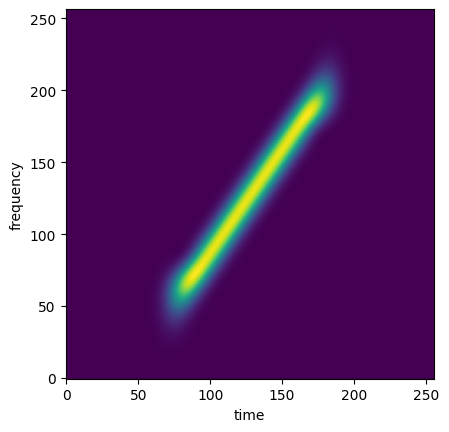

In [22]:
N = 256 # Signal length in time samples.
sb = SignalBank(N=N,Nsub=N//2)
signal_1 = sb.signal_linear_chirp()

# Let's see the signal spectrogram:
stft = get_stft(signal_1)
spectrogram = np.abs(stft)**2
plt.imshow(spectrogram, origin='lower')
plt.xlabel('time'); plt.ylabel('frequency')

# Finally, create the dictionary of signals for the benchmark
signals = {'signal_1':signal_1}

## Creating a dictionary of methods to compare

Before defining the benchmark, let's create a dictionary of methods. Our first signal detection method is based on a matched filter. It will search for a template signal within the signal we probe, and indicate if the correlation between both template and probing signal surpasses a certain threshold. 

In [23]:
from scipy.signal import convolve
def matched_filter(signal, template):
    """
    Applies a matched filter to a signal using a given template.
    """
    
    matched_filter_kernel = template[::-1] 
    # Perform convolution
    output = convolve(signal, matched_filter_kernel, mode='same')
    return output

def detection_method_1(signal):
    """ 
    Signal detection based on matching filter.
    """
    output = matched_filter(signal,template=signal_1)
    output /= np.max(output)

    if len(output[output>0.9])==1:
        return True
    else:
        return False

# Example usage:
signal = np.random.randn(len(signal_1)) + signal_1  # Noisy signal! Should output "True" most of the times.
filtered_signal = matched_filter(signal, signal_1)
filtered_signal /= np.max(filtered_signal)
print(detection_method_1(signal))

True


The second signal detection method is a detection test. The null hypothesis is that the probed signal is composed of only white Gaussian noise, whereas the alternative hypothesis is that the probed signal is actually a mixture of signal and white Gaussian noise.

The test is based on considering that the distribution of each pixel of the spectrogram of white Gaussian noise is distributed as $\chi^2$ with two degrees of freedom. We then evaluate if any of ten random positions of the spectogram are above a threshold selected to have a false alarm rate of 5%.

In [24]:
import scipy.stats as ss
def detection_method_2(signal):
    stft = get_stft(signal,scaling='psd')
    std_estim = np.median(np.abs(np.real(stft)))/0.6745
    num = ss.chi2.isf(0.05/10,2)
    thr = num*std_estim**2
    aux = np.abs(stft.flatten())**2
    positions = np.random.randint(0,stft.size,size=10)
    if np.any( aux[positions] > thr):
        return True
    else:
        return False
    
# det = 0
# for i in range(500):
#     noise = np.random.randn(32)
#     det += detection_method_2(noise)

# det/500

Finally, we create a dictionary of methods to compare, instantiate a benchmark object and run the comparisons.

In [25]:
methods = {'detection_method_1':detection_method_1,'detection_method_2':detection_method_2}

benchmark = Benchmark(task='detection',
                      methods=methods,
                    #   parameters=parameters,
                      signal_ids=signals,
                      SNRin=[-10,-5,0,5],
                      repetitions=30,
                      N = N)

In [26]:
benchmark.run()

Running benchmark...
- Signal signal_1


100%|██████████| 4/4 [00:00<00:00, 14.54it/s]

The test has finished.


{'perf_metric': {'signal_1': {-10: {'detection_method_1': {'((), {})': [True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      False,
      True,
      False,
      True,
      True,
      False,
      True,
      True,
      True]},
    'detection_method_2': {'((), {})': [False,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      True,
      False,
      False,
      False,
      False,
      False,
      True,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      False,
      True,
      False,
      False,
      False]}},
   -5: {'detection_method_1': {'((), {})': [True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,
      True,

## Showcasing results

Once results are available we can display summary plots using the functionality of the `ResultsInterpreter` class.

In [27]:
# Summary interactive plots with Plotly and a report.
from plotly.offline import  iplot
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"
interpreter = ResultsInterpreter(benchmark)
figs = interpreter.get_summary_plotlys(bars=True,ylabel='Prob. of Detection')
for fig in figs:
    iplot(fig)